
# 🧪 Midterm Practice — Data Analysis & Probability Distributions

**Nội dung:**  
1) Đọc dữ liệu từ file, tính các đặc trưng, trực quan hóa dữ liệu.  
2) Tính xác suất và phân vị của phân phối **Nhị thức (Binomial), Poisson, Chuẩn (Normal)**.  
3) Khoảng tin cậy cho **tỷ lệ**.

> Gợi ý: Notebook này **tự chạy được** với các dataset bạn đã đưa:  
`03_FRESH15.xls`, `02_BODYTEMP.xls`, `06_BEARS.xls`, `13_VOLTAGE.xls`, `18_M&M.xls`, `19_SCREWS.xls`, `24_FICO.xls`, `gapminder_tidy.csv`, `diamonds.csv`.


In [3]:

# Chuẩn bị thư viện
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lưu ý cho phần vẽ: dùng matplotlib, mỗi biểu đồ 1 figure riêng, không set màu cụ thể.
print("Libs OK")


Libs OK



## 0) Chọn dataset để luyện
- Đổi đường dẫn `DATA_PATH` cho dataset bạn muốn làm.
- Notebook có kiểm tra cột để tự gợi ý bài tập phù hợp.


In [6]:

# Liệt kê file có sẵn trong /mnt/data (nếu bạn đang chạy môi trường này)
candidates = [
    "03_FRESH15.xls",
    "02_BODYTEMP.xls",
    "06_BEARS.xls",
    "13_VOLTAGE.xls",
    "18_M&M.xls",
    "19_SCREWS.xls",
    "24_FICO.xls",
    "gapminder_tidy.csv",
    "diamonds.csv",
]

existing = [p for p in candidates if os.path.exists(p)]
existing


['03_FRESH15.xls',
 '02_BODYTEMP.xls',
 '06_BEARS.xls',
 '13_VOLTAGE.xls',
 '18_M&M.xls',
 '19_SCREWS.xls',
 '24_FICO.xls',
 'gapminder_tidy.csv',
 'diamonds.csv']

In [7]:

# TODO: Chọn 1 file từ danh sách 'existing' ở cell trên hoặc điền đường dẫn của bạn
DATA_PATH = existing[0] if existing else "03_FRESH15.xls"
DATA_PATH


'03_FRESH15.xls'


## 1) Đọc dữ liệu & khám phá sơ bộ
**Yêu cầu:**
- Đọc file
- In `head(5)`, `shape`, `dtypes`
- Kiểm tra thiếu dữ liệu


In [8]:

# Đọc dữ liệu linh hoạt theo phần mở rộng
ext = os.path.splitext(DATA_PATH)[1].lower()
if ext in [".xls", ".xlsx"]:
    try:
        df = pd.read_excel(DATA_PATH)
    except Exception:
        try:
            df = pd.read_excel(DATA_PATH, engine="xlrd")
        except Exception:
            df = pd.read_excel(DATA_PATH, engine="openpyxl")
elif ext in [".csv", ".txt"]:
    df = pd.read_csv(DATA_PATH)
else:
    # last resort
    df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
print("\nDtypes:")
print(df.dtypes)
print("\nMissing per column:")
print(df.isna().sum())


Shape: (67, 5)


,SEX,WTSEP,WTAPR,BMISP,BMIAP
0,M,72,59,22.02,18.14
1,M,97,86,19.70,17.44
2,M,74,69,24.09,22.43
3,M,93,88,26.97,25.57
4,F,68,64,21.51,20.10



Dtypes:
SEX       object
WTSEP      int64
WTAPR      int64
BMISP    float64
BMIAP    float64
dtype: object

Missing per column:
SEX      0
WTSEP    0
WTAPR    0
BMISP    0
BMIAP    0
dtype: int64



## 2) Làm sạch dữ liệu nhanh
- Chuẩn hóa cột `sex/gender` (nếu có) → thêm cột nhị phân `*_num`.
- Chuyển các cột object có dạng số ("1,200", "45%") thành số `_num`.


In [9]:

df = df.copy()

# Chuẩn hóa sex/gender (nếu có)
for col in df.columns:
    if str(col).strip().lower() in ("sex", "gender"):
        df[col] = df[col].astype(str).str.strip().str.upper()
        mapping = {"M":1, "MALE":1, "NAM":1, "F":0, "FEMALE":0, "NU":0, "NỮ":0}
        df[col + "_num"] = df[col].map(mapping)

def to_numeric_series(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("%", "", regex=False)
         .str.replace(r"[^\d\.\-\+eE]", "", regex=True)
         .str.strip()
         .pipe(pd.to_numeric, errors="coerce")
    )

df_num = df.select_dtypes(include="number").copy()
for c in df.select_dtypes(include="object").columns:
    cand = to_numeric_series(df[c])
    if cand.notna().sum() >= max(3, int(0.5*len(df))):
        df_num[c + "_num"] = cand

print("Numeric columns considered:")
print(df_num.columns.tolist())


Numeric columns considered:
['WTSEP', 'WTAPR', 'BMISP', 'BMIAP', 'SEX_num']



## 3) Đặc trưng thống kê
- Tính: `mean`, `median`, `std`, `min`, `max`, `count`
- In `describe()`


In [10]:

print("--- STATS ---")
stats_df = pd.DataFrame({
    "mean": df_num.mean(numeric_only=True),
    "median": df_num.median(numeric_only=True),
    "std": df_num.std(numeric_only=True),
    "min": df_num.min(numeric_only=True),
    "max": df_num.max(numeric_only=True),
    "count": df_num.count()
})
display(stats_df)

print("\n--- DESCRIBE ---")
display(df_num.describe())


--- STATS ---


,mean,median,std,min,max,count
WTSEP,65.059701,64.00,11.285390,42.00,97.00,67
WTAPR,66.238806,66.00,11.284327,47.00,105.00,67
BMISP,22.030000,21.73,3.308901,15.08,36.57,67
BMIAP,22.484179,22.31,3.602527,16.89,40.86,67
SEX_num,0.477612,0.00,0.503268,0.00,1.00,67



--- DESCRIBE ---


,WTSEP,WTAPR,BMISP,BMIAP,SEX_num
count,67.000000,67.000000,67.000000,67.000000,67.000000
mean,65.059701,66.238806,22.030000,22.484179,0.477612
std,11.285390,11.284327,3.308901,3.602527,0.503268
min,42.000000,47.000000,15.080000,16.890000,0.000000
25%,56.500000,58.000000,19.965000,20.230000,0.000000
50%,64.000000,66.000000,21.730000,22.310000,0.000000
75%,70.500000,70.000000,23.160000,23.860000,1.000000
max,97.000000,105.000000,36.570000,40.860000,1.000000



## 4) Trực quan hóa
- Vẽ **1 histogram** cho cột số đầu tiên
- Vẽ **1 boxplot** cho tối đa 10 cột số đầu tiên
- Vẽ **1 scatter** cho 2 cột số đầu tiên (nếu có)
- Vẽ **heatmap tương quan** (dùng `imshow`)


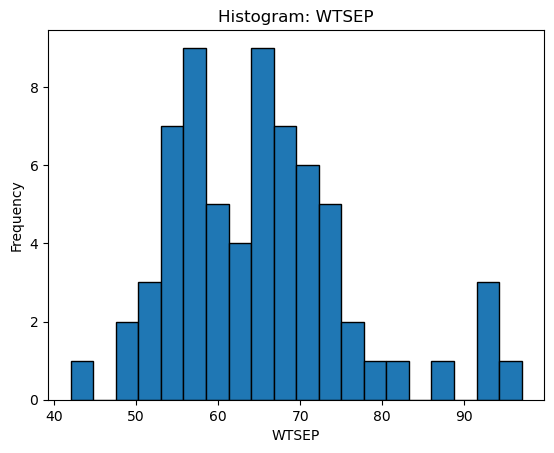

/var/folders/_l/jkzl_h7n1h9241fb7cqx7k5w0000gn/T/ipykernel_35838/2834398446.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_num[c].dropna() for c in cols], labels=cols, vert=True)


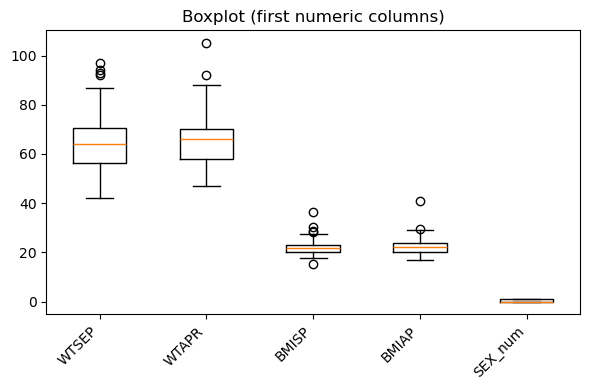

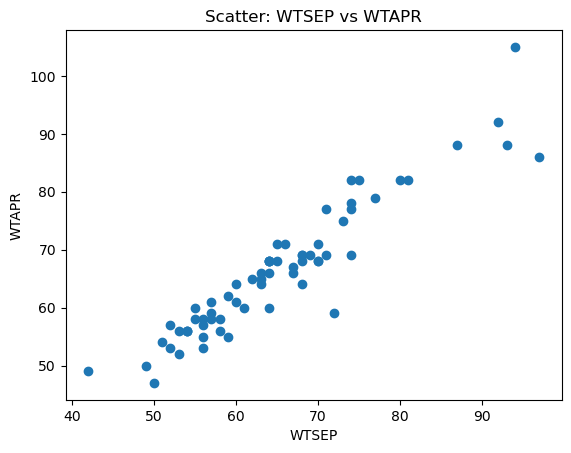

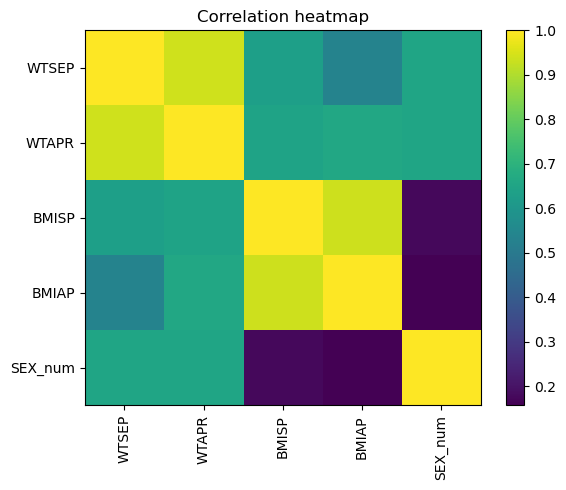

In [12]:

num_cols = df_num.columns.tolist()

# Histogram
if len(num_cols) >= 1:
    col = num_cols[0]
    plt.figure()
    plt.hist(df_num[col].dropna(), bins=20, edgecolor = 'black')
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()

# Boxplot
cols = num_cols[:10]
if len(cols) >= 1:
    plt.figure(figsize=(max(6, 0.6*len(cols)), 4))
    plt.boxplot([df_num[c].dropna() for c in cols], labels=cols, vert=True)
    plt.title("Boxplot (first numeric columns)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Scatter
if len(num_cols) >= 2:
    xcol, ycol = num_cols[0], num_cols[1]
    plt.figure()
    plt.scatter(df_num[xcol], df_num[ycol])
    plt.title(f"Scatter: {xcol} vs {ycol}")
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.show()

# Correlation heatmap
if len(num_cols) >= 2:
    corr = df_num.corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.title("Correlation heatmap")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.tight_layout()
    plt.show()



## 5) Bài tập theo cột đặc thù (nếu tồn tại)
- Nếu có `BMIAP` và `BMISP`: đếm tỷ lệ BMI giảm (BMIAP < BMISP) và khoảng tin cậy 90% cho tỷ lệ.
- Nếu có `SEX`/`GENDER`: tính trung bình 1 biến theo giới.
- Nếu có `height` (inch) và `weight` (pound): đổi đơn vị và tính BMI.


In [13]:

# BMI decrease & 90% CI
if set(["BMIAP","BMISP"]).issubset(df.columns):
    n = len(df)
    x = (df["BMIAP"] < df["BMISP"]).sum()
    p_hat = x / n if n else np.nan
    z = 1.645
    se = math.sqrt(p_hat*(1-p_hat)/n) if n else np.nan
    lo = p_hat - z*se
    hi = p_hat + z*se
    print(f"[BMI decrease] {x}/{n} -> p̂={p_hat:.3f}, 90% CI=({lo:.3f}, {hi:.3f})")

# Group mean by SEX/GENDER for first numeric column
sexcol = None
for c in df.columns:
    if str(c).strip().lower() in ("sex","gender"):
        sexcol = c
        break

if sexcol and len(df_num.columns) >= 1:
    gmean = df.groupby(sexcol)[df_num.columns[0]].mean(numeric_only=True)
    print(f"Group mean by {sexcol} for {df_num.columns[0]}:")
    print(gmean)

# Height/Weight convert + BMI
hcol_candidates = [c for c in df.columns if str(c).lower().startswith("height")]
wcol_candidates = [c for c in df.columns if str(c).lower().startswith("weight")]
if hcol_candidates and wcol_candidates:
    hcol, wcol = hcol_candidates[0], wcol_candidates[0]
    # Thử đoán inch->cm, pound->kg (nếu dữ liệu hợp lý)
    h_cm = df[hcol]*2.54
    w_kg = df[wcol]*0.453592
    bmi = w_kg / ((h_cm/100.0)**2)
    print(f"BMI preview (using {hcol},{wcol}):")
    display(bmi.describe())


[BMI decrease] 18/67 -> p̂=0.269, 90% CI=(0.180, 0.358)
Group mean by SEX for WTSEP:
SEX
F    58.057143
M    72.718750
Name: WTSEP, dtype: float64



# Phần B — Xác suất & Phân vị

Cho biết và áp dụng 3 phân phối: **Binomial**, **Poisson**, **Normal**.


In [14]:

from math import comb
from scipy.stats import binom, poisson, norm

# --- Binomial ---
# TODO: điền n, p, k phù hợp đề
n, p, k = 10, 0.3, 3
P_eq = binom.pmf(k, n, p)         # P(X = k)
P_le = binom.cdf(k, n, p)         # P(X <= k)
k90 = binom.ppf(0.90, n, p)       # 90th percentile
print("[Binomial] P(X=k)=", P_eq, "  P(X<=k)=", P_le, "  k_90=", k90)

# --- Poisson ---
lam = 6
P2 = poisson.pmf(2, lam)
P_ge_3 = 1 - poisson.cdf(2, lam)  # P(X >= 3)
x95_pois = poisson.ppf(0.95, lam)
print("[Poisson] P(X=2)=", P2, "  P(X>=3)=", P_ge_3, "  x_95%=", x95_pois)

# --- Normal ---
mu, sigma = 100, 15
P_less_120 = norm.cdf(120, mu, sigma)
P_between = norm.cdf(115, mu, sigma) - norm.cdf(85, mu, sigma)
x90 = norm.ppf(0.90, mu, sigma)
print("[Normal] P(X<120)=", P_less_120, "  P(85<X<115)=", P_between, "  x_90%=", x90)


[Binomial] P(X=k)= 0.2668279319999998   P(X<=k)= 0.6496107184000002   k_90= 5.0
[Poisson] P(X=2)= 0.04461753917999444   P(X>=3)= 0.938031195583341   x_95%= 10.0
[Normal] P(X<120)= 0.9087887802741321   P(85<X<115)= 0.6826894921370859   x_90%= 119.22327348316901



## Khoảng tin cậy cho **tỷ lệ** (one-sample, normal approx)
Công thức 90% CI cho tỷ lệ \(p\) với mẫu \(n\), tần số \(x\), \(\hat p = x/n\):
\[
\hat p \pm z_{0.05}\sqrt{\hat p(1-\hat p)/n},\quad z_{0.05}=1.645
\]
Điền số thực tế của bạn:


In [15]:

# TODO: thay x, n bằng dữ liệu của bạn
x, n = 6, 15
p_hat = x/n
z = 1.645
se = math.sqrt(p_hat*(1-p_hat)/n)
lo, hi = p_hat - z*se, p_hat + z*se
print(f"p̂={p_hat:.3f}, 90% CI=({lo:.3f}, {hi:.3f})")


p̂=0.400, 90% CI=(0.192, 0.608)



---

**Kết thúc bài luyện.**  
Bạn có thể đổi `DATA_PATH` để luyện với các dataset khác nhau và lặp lại các bước.
